In [1]:
import sklearn
print(sklearn.__version__)

0.20.1


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## Problem 1: Linear Regression (50 points)

In [3]:
data = np.loadtxt('data\curve80.txt')
X = data[:,0]
X = np.atleast_2d(X).T # code expects shape (M,N) so make sure it's 2-dimensional
Y = data[:,1]
Xtr,Xte,Ytr,Yte = train_test_split(X, Y, test_size=0.25, shuffle=False)

### 1. Print the shapes of these four objects. (5 points)

In [4]:
print(Xtr.shape,Xte.shape,Ytr.shape,Yte.shape)

(60, 1) (20, 1) (60,) (20,)


### 2.

In [5]:
lr = LinearRegression().fit(Xtr, Ytr) # fit the model
xs = np.linspace(0,10,200) # densely sample possible x-values
xs = xs[:,np.newaxis] # force "xs" to be an Mx1 matrix (expected by our code)
ys = lr.predict(xs) # make predictions at xs

#### a. Plot the training data, test data, and prediction function in a single plot. (10 points)

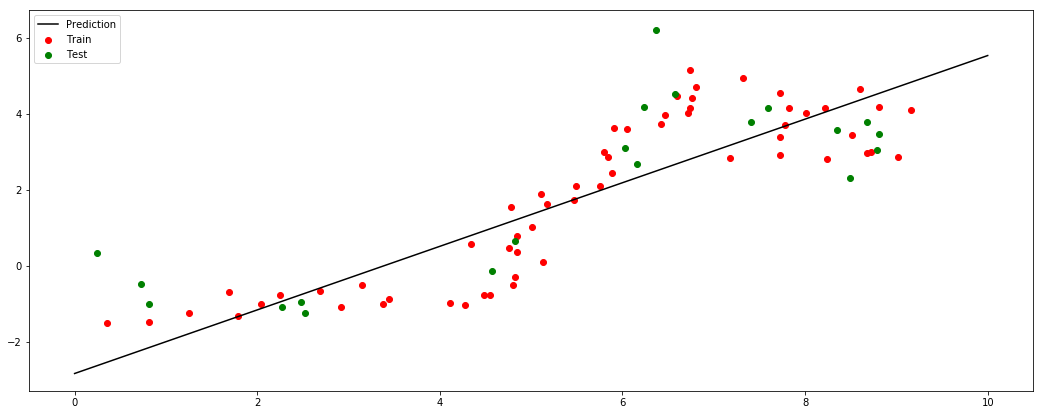

In [6]:
plt.rcParams['figure.figsize'] = (18.0, 7.0) # axis-limit, use it later also
lines = plt.plot(xs,ys, color='black', label='Prediction') # xs/xtr/xte vs. ys/ytr/yte with different colors
train = plt.scatter(Xtr, Ytr, color='red', label='Train')
test = plt.scatter(Xte, Yte, color='green', label='Test')
plt.legend() # add legend for each color
plt.show()

#### b. Print the linear regression intercept and coefficient. And verify that they match your plot. (5 points)

In [7]:
# intercept of the line with Y axis
# coef: slope
print(lr.intercept_, lr.coef_)

-2.82765048766481 [0.83606916]


#### c. What is the mean squared error of the predictions on the training and test data? (5 points)

In [8]:
# Make predictions
Ytr_pred = lr.predict(Xtr) # make y predictions using fitted model
Yte_pred = lr.predict(Xte)
# Compute mean squared error
def mse(y_pred, y):
    return np.mean((y - y_pred)**2)
print('Train MSE:', mse(Ytr_pred, Ytr))
print('Test MSE:', mse(Yte_pred, Yte))

Train MSE: 1.1277119556093909
Test MSE: 2.2423492030101237


### 3.

In [9]:
Xtr2 = np.zeros( (Xtr.shape[0],2) ) # create Mx2 array to store features
Xtr2[:,0] = Xtr[:,0] # place original "x" feature as X1
Xtr2[:,1] = Xtr[:,0]**2 # place "x^2" feature as X2
demox = np.arange(4).reshape(4,1)

# y = x + x^2
poly2 = PolynomialFeatures(2, include_bias=False).fit(Xtr)
demoxx = poly2.transform(demox)

# y = 1 + x + x^2 + x^3
poly3 = PolynomialFeatures(3, include_bias=True).fit(Xtr)
demoxxx = poly3.transform(demox)

poly = PolynomialFeatures(2, include_bias=False).fit(Xtr)
Xtr2 = poly.transform(Xtr)

#### a. For each model, plot the learned prediction function f (x). (10 points)

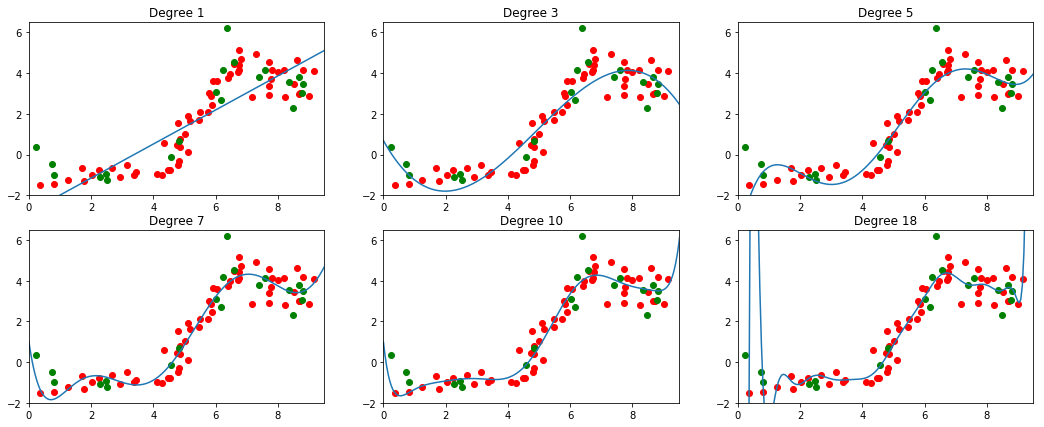

In [10]:
degrees = [1, 3, 5, 7, 10, 18]
# Plot settings
plt.rcParams['figure.figsize'] = (18.0, 7.0)
fig, ax = plt.subplots(2,3)
axFlat = [a for row in ax for a in row] # 2x3 subplots as simple list
err_train = []
err_test = []
for i, d in enumerate(degrees):
    # Create polynomial features
    poly = PolynomialFeatures(d, include_bias=False).fit(Xtr)
    XtrP = poly.transform(Xtr)
    poly2 = PolynomialFeatures(d, include_bias=False).fit(Xte)
    XteP = poly2.transform(Xte)
    # Scale features to standard distribution (mean 0, variance 1)
    scaler = StandardScaler().fit(XtrP)
    XtrP = scaler.transform(XtrP)
#     scaler2 = StandardScaler().fit(XteP)
    XteP = scaler.transform(XteP)
    # Fit the model
    lrP = LinearRegression().fit(XtrP, Ytr)
    # Plot the prediction function
    xsP = poly.transform(xs)
    xsP = scaler.transform(xsP)
    ysP = lrP.predict(xsP)
    # plot the train and test datapoints
    axFlat[i].set_ylim(top=6.5,bottom=-2)
    axFlat[i].set_xlim(right=9.5)
    axFlat[i].set_title('Degree ' + str(degrees[i]))
    axFlat[i].plot(xs,ysP)
    axFlat[i].scatter(Xtr,Ytr,color = "red")
    axFlat[i].scatter(Xte,Yte,color = "green")
    axisSize = axFlat[i].axis()
    axFlat[i].plot() # plot the fitted curve
    axFlat[i].axis(axisSize)
    # Make predictions
    YtrP_pred = lrP.predict(XtrP)
    YteP_pred = lrP.predict(XteP)
    # Save train and test errors for (b)
    err_train.append(mse(YtrP_pred, Ytr))
    err_test.append(mse(YteP_pred, Yte))

#### b. Plot the training and test errors on a log scale ( semilogy ) as a function of the model degree. (10 points)

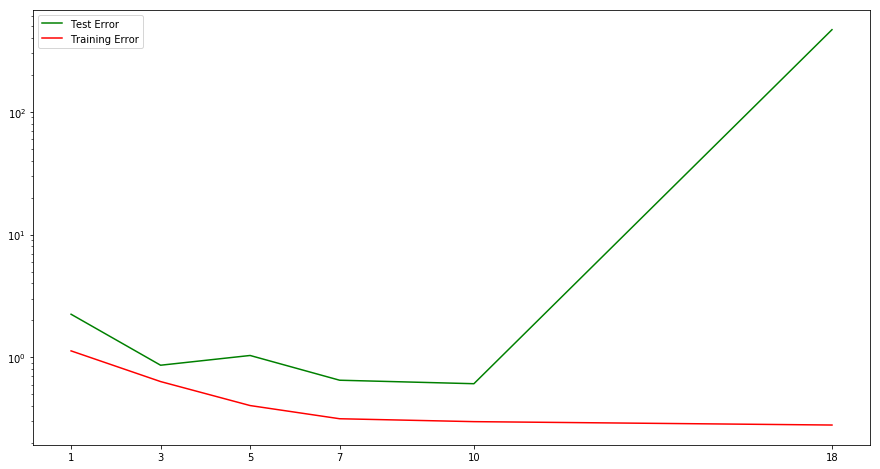

In [11]:
plt.rcParams['figure.figsize'] = (15.0, 8.0)
# plot degrees vs. err_train and degrees vs. err_test on the same plot
plt.semilogy(degrees,err_test,label="Test Error", color="green")
plt.semilogy(degrees,err_train,label="Training Error", color="red")
plt.xticks([1,3,5,7,10,18])
plt.legend()
plt.show()


#### c. What polynomial degree do you recommend? (5 points)

Looking at the plot from part B, I would recommend degree 10 since it has the lowest test error compare to other degrees.

## Problem 2: Cross-validation (30 points)

#### 1. Plot the five-fold cross-validation error (with semilogy , as before) as a function of degree. (10 points)

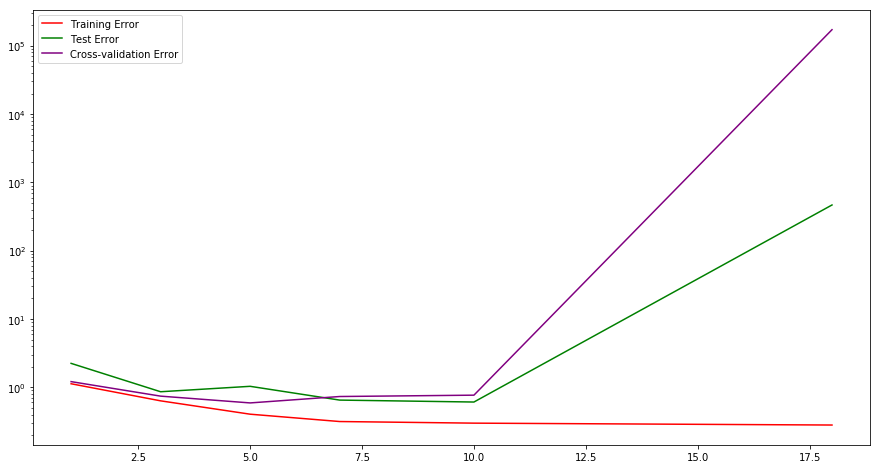

In [12]:
def run_cv(d, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    err_cv = []
    kf.get_n_splits(X)
    for train_idx, test_idx in kf.split(Xtr, Ytr):
        Xtr_cv, Xte_cv = Xtr[train_idx], Xtr[test_idx]
        Ytr_cv, Yte_cv = Ytr[train_idx], Ytr[test_idx]
        # Create polynomial features
        poly = PolynomialFeatures(d, include_bias=False).fit(Xtr_cv)
        Xtr_cv = poly.transform(Xtr_cv)
#         poly2 = PolynomialFeatures(d, include_bias=False).fit(Xte_cv)
        Xte_cv = poly.transform(Xte_cv)
        # Scale features to standard distribution (mean 0, variance 1)
        scaler = StandardScaler().fit(Xtr_cv)
        Xtr_cv = scaler.transform(Xtr_cv)
        Xte_cv = scaler.transform(Xte_cv)
        # Fit the model
        lrP = LinearRegression().fit(Xtr_cv, Ytr_cv)
        # Make predictions on the test fold
        Ytecv_pred = lrP.predict(Xte_cv)
        # Return MSE on the test fold
        err_cv.append(mse(Ytecv_pred, Yte_cv))
    return np.mean(err_cv)
n_folds = 5
err_cv = []
for d in degrees:
    err_cv.append(run_cv(d, n_folds))

plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.semilogy(degrees,err_train,label="Training Error", color="red") # degrees vs. training error (from P1)
plt.semilogy(degrees,err_test,label="Test Error", color="green") # degrees vs. validation error (from P1)
plt.semilogy(degrees,err_cv,label="Cross-validation Error", color="purple")# degrees vs. cross-validation estimate of validation linewidth=2)
plt.legend()
plt.show()

#### 2. How do the MSE estimates from five-fold cross-validation compare to the MSEs evaluated on the actual test data (Problem 1)? (5 points)

Initially, the resulting plot shows a similar MSE estimates from five-fold cross-validation compare to the MSEs evaluated on the actual test data from Problem 1. However, after degree 10, the five-fold cross-validation MSE increases at an exponentially faster rate than the MSEs from the actual test data.

#### 3. Which polynomial degree do you recommend based on five-fold cross-validation error? (5 points)

Based on the plot above, I would recommend degree 5 on the five-fold cross-validation error as it has the smallest error compare to other degrees.

#### 4. For the degree that you picked in step 3, plot (with semilogy ) the cross-validation error as the number of folds is varied from nFolds = 2, 3, 4, 5, 6, 10, 12, 15. What pattern do you observe, and how do you explain why it occurs? (15 points)

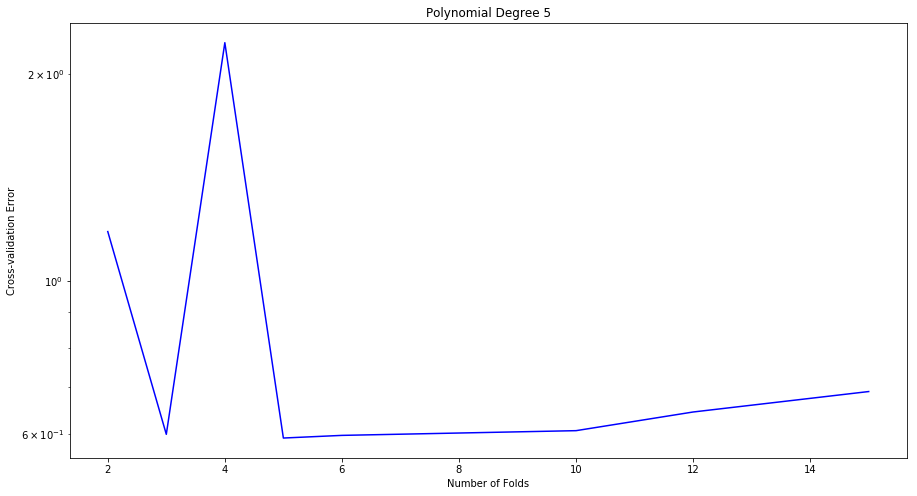

In [13]:
d = degrees[np.argmin(err_cv)]
folds = [2, 3, 4, 5, 6, 10, 12, 15]
err_cv_folds = []
for k in folds:
    err_cv_folds.append(run_cv(d, k))
    
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.semilogy(folds, err_cv_folds, color="blue") # folds vs. err_cv_folds
plt.xlabel("Number of Folds")
plt.ylabel("Cross-validation Error")
plt.title("Polynomial Degree 5")
plt.show()

From the plot above, we can see that when the number of folds is small (2-5), the cross-validation error increases and decreases dramatically. When fold=5, it appears to have the smallest amount of error. And for number of folds greater than 5, the error increases slowly. I believe the spike in error for small number of folds is due to a part of the data given in the text file is different from the rest of the data.

## Problem 3: Gaussian Probability Distribution Theory (15 points)

#### a. (Derive evidence expression): 5 points.

(Scanned in report)

#### b. (Plot contours of constant density): 5 points.

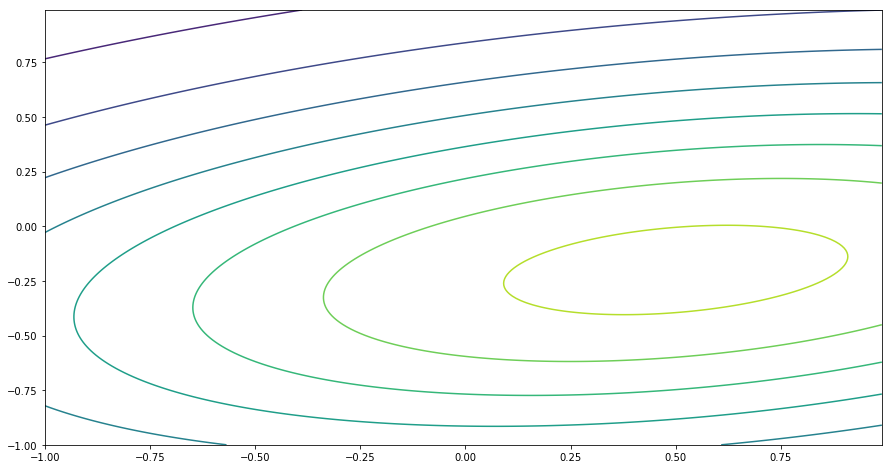

In [14]:
from scipy.stats import multivariate_normal
# generate the density function
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

# plot contours of constant density
plt.contour(x, y, rv.pdf(pos))
plt.show()

#### c. (Derive Mahalanobis distance): 5 points.

(Scanned in report)

## Problem 4: Statement of Collaboration (5 points)

The homework was done individually and without any discussion. However, I was able to get help to most of the problems I was facing through browsing Piazza as many questions I had were answered on the forum. I also received help from going to the discussion section as well as the discussion slides to get me started on the homework problems.